In the previous notebook, we covered the following key concepts:

- **Embeddings**:
  - Defined as dense vector representations of tokens that capture their meanings.
  - Implemented using PyTorch to create an embedding layer for the sentence "The cat sat on the mat."
  - Mapped tokens to unique IDs and converted them to embeddings.

- **Positional Encoding**:
  - Provided information about the position of each token in a sequence.
  - Implemented a function to generate positional encodings using sine and cosine functions.
  - Combined positional encodings with embeddings to create context-aware representations.


In today’s session, we will focus on two crucial concepts in the transformer architecture:

1. **Self-Attention**: Understanding how the model evaluates the significance of each word in relation to others in a sentence.
2. **Multi-Head Self-Attention**: Exploring how multiple attention mechanisms work together to capture different aspects of the input.

Let’s dive into the first topic: **Self-Attention**.

-----

# Self-Attention

## What is Self-Attention?

Self-attention is a mechanism that allows the model to weigh the importance of each word in a sentence relative to all other words. It helps the model focus on relevant information, enabling a richer understanding of language.

Consider the task of translating a sentence from one language to another. Translating a sentence word-by-word does not work effectively because it fails to capture the context and relationships between words.

For example, let's say we have the French sentence:
- **"Le chat noir mange la souris blanche."**

Translating each word individually to English would result in:
- **"The black cat eats the white mouse."**

However, this translation does not accurately convey the meaning because it doesn't consider the context and order of words. Self-attention can help address this issue by allowing the model to focus on relevant words based on their relationships.

## How Self-Attention Works

Let's break down the self-attention mechanism step by step, using the French sentence as an example.

### Example Sentence

**French Sentence: `"Le chat noir mange la souris blanche."`**

**English Translation: `"The black cat eats the white mouse."`**

### Step 1: Input Representation

   - Each word in the input sentence is transformed into a vector representation using embeddings. These embeddings capture the meanings of words in a multi-dimensional space.

**Embeddings**:
- Let's assume the embeddings for our French tokens are as follows:

| Token | Embedding Vector          |
|-------|---------------------------|
| Le    | [0.1, 0.2, 0.3]           |
| chat  | [0.4, 0.5, 0.6]           |
| noir  | [0.7, 0.8, 0.9]           |
| mange | [0.1, 0.4, 0.7]           |
| la    | [0.1, 0.2, 0.3]           |
| souris| [0.3, 0.6, 0.9]           |
| blanche| [0.7, 0.8, 0.9]          |
|  **.**     | [0.1, 0.1, 0.1]          |


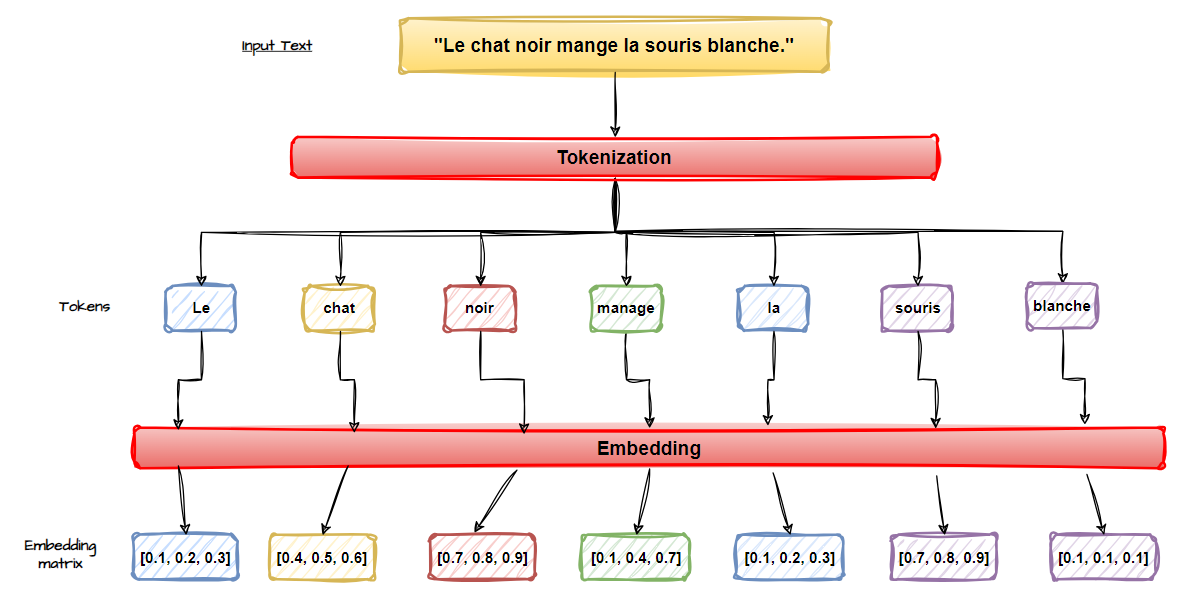

In [1]:
import torch
import torch.nn as nn

# Define the vocabulary and embeddings
tokens = ["Le", "chat", "noir", "mange", "la", "souris", "blanche"]

embeddings_dict = {
    "Le": [0.1, 0.2, 0.3],
    "chat": [0.4, 0.5, 0.6],
    "noir": [0.7, 0.8, 0.9],
    "mange": [0.1, 0.4, 0.7],
    "la": [0.1, 0.2, 0.3],
    "souris": [0.3, 0.6, 0.9],
    "blanche": [0.7, 0.8, 0.9],
}

In [2]:
# Convert tokens to embeddings
embeddings = torch.tensor([embeddings_dict[token] for token in tokens])
print("Embeddings:\n", embeddings)

Embeddings:
 tensor([[0.1000, 0.2000, 0.3000],
        [0.4000, 0.5000, 0.6000],
        [0.7000, 0.8000, 0.9000],
        [0.1000, 0.4000, 0.7000],
        [0.1000, 0.2000, 0.3000],
        [0.3000, 0.6000, 0.9000],
        [0.7000, 0.8000, 0.9000]])


### Step 2: Creating Query, Key, and Value Vectors

   - Each word’s embedding is transformed into three vectors:
     - **Query (Q)**: Represents the word currently being focused on.
     - **Key (K)**: Represents all other words in the sequence.
     - **Value (V)**: Holds the actual information used in the output.
   - This transformation is done through learned linear projections:
     - $$ Q = W_Q \cdot x $$
     - $$ K = W_K \cdot x $$
     - $$ V = W_V \cdot x $$
   - Where $$ W_Q, W_K, W_V $$ are weight matrices learned during training.

**Transformations**:
- For simplicity, let's assume learned weight matrices are as follows:

| Weight Matrix | Q     | K     | V     |
|---------------|-------|-------|-------|
| W_Q           | [1, 0] | [0, 1] | [1, 1] |
| W_K           | [1, 0] | [0, 1] | [1, 1] |
| W_V           | [1, 0] | [0, 1] | [1, 1] |


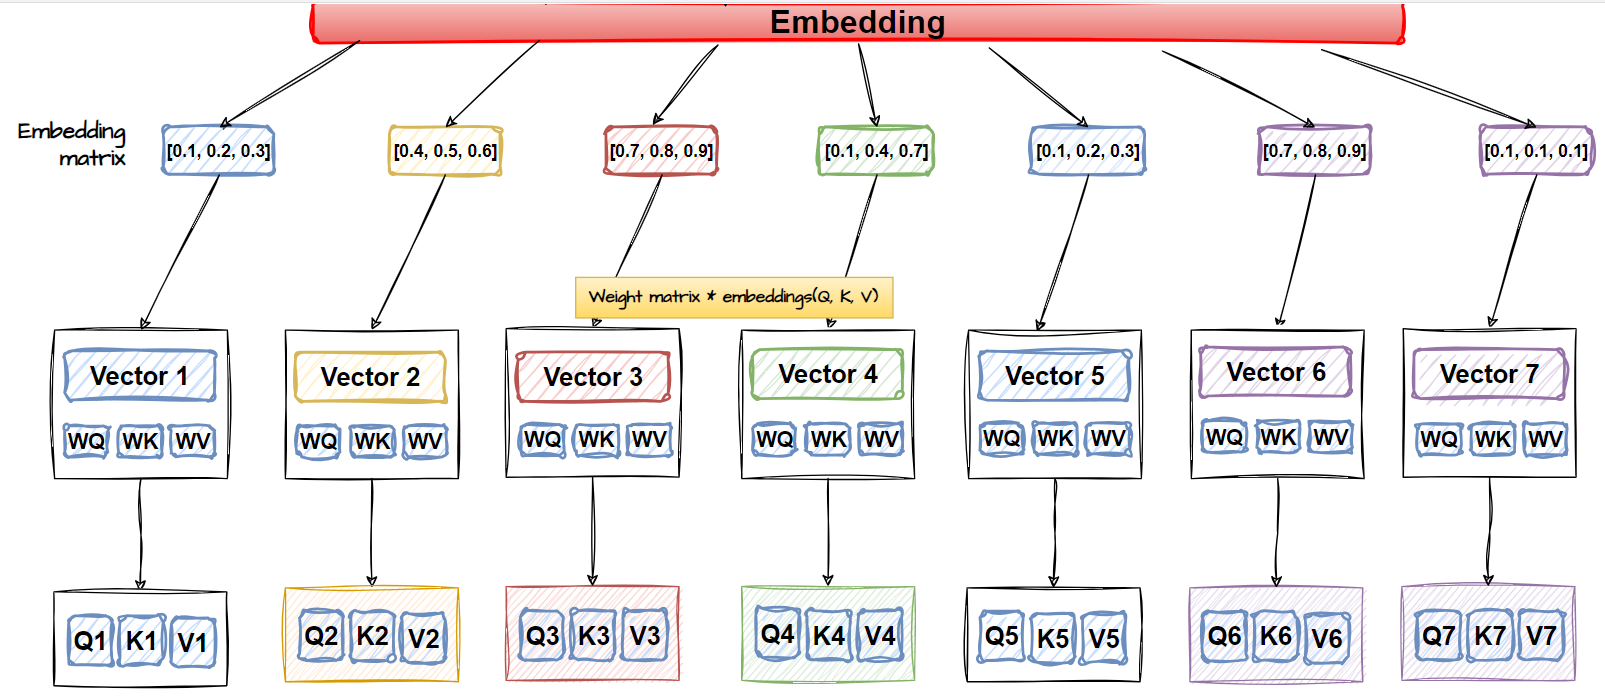

In [3]:
# Define weight matrices for Q, K, V (for simplicity, using random values)
W_Q = torch.tensor([[1, 0], [0, 1], [1, 1]])
W_K = torch.tensor([[1, 0], [0, 1], [1, 1]])
W_V = torch.tensor([[1, 0], [0, 1], [1, 1]])

In [4]:
# Create Q, K, V vectors for each word
Q = torch.matmul(embeddings, W_Q.T)
K = torch.matmul(embeddings, W_K.T)
V = torch.matmul(embeddings, W_V.T)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (7x3 and 2x3)

In [ ]:
print("Query Vectors:\n", Q)
print("Key Vectors:\n", K)
print("Value Vectors:\n", V)

### Step 3: Calculating Attention Scores

   - The model calculates a score for each word indicating how much attention should be paid to every other word:
     $$ \text{score}(Q, K) = Q \cdot K^T $$
   - The resulting scores indicate the relevance of each word relative to the word being processed.


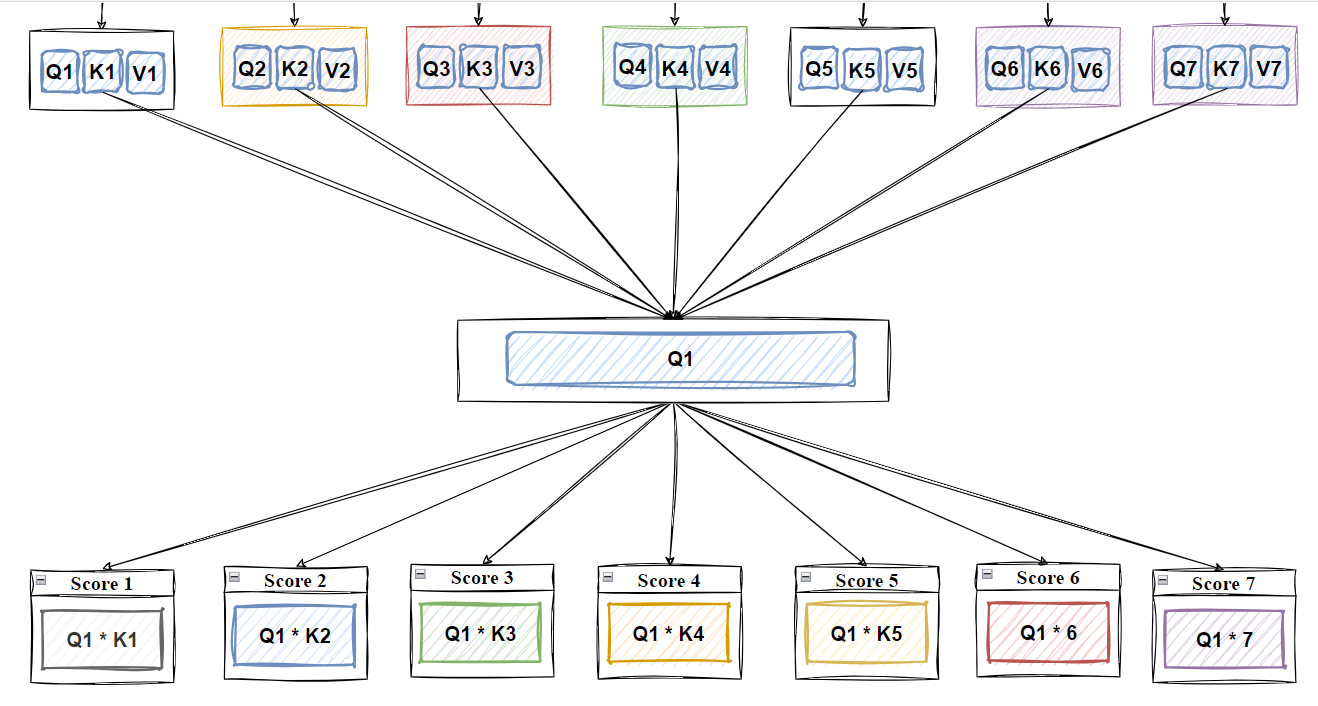

In [ ]:
# Calculate attention scores for the first word "Le"
attention_scores = torch.matmul(Q[0], K.T)
print("Attention Scores for 'Le':\n", attention_scores)

### Step 4: Normalizing Scores

   - Scores are normalized using the softmax function to convert them into probabilities, ensuring all attention weights sum to 1:
     - $$ \text{attention\_weights} = \text{softmax}\left(\frac{\text{score}(Q, K)}{\sqrt{d_k}}\right) $$
   - Here, $$ d_k $$ is the dimension of the Key vectors, and the division by $$ \sqrt{d_k} $$ helps stabilize gradients during training.

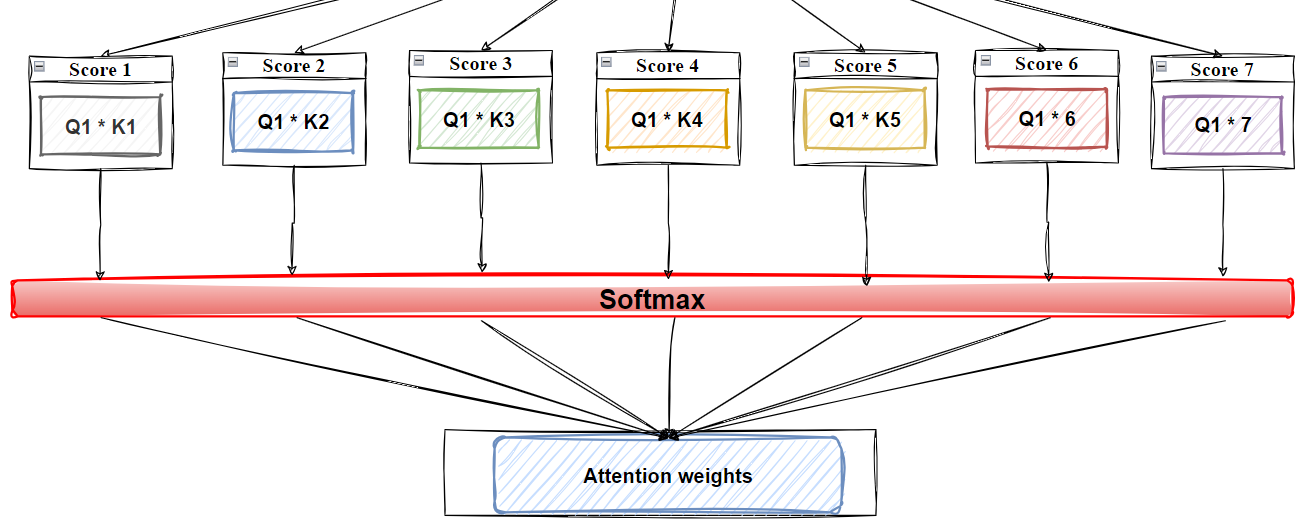

In [ ]:
# Normalize scores using softmax
attention_weights = torch.nn.functional.softmax(attention_scores, dim=-1)
print("Attention Weights for 'Le':\n", attention_weights)

### Step 5: Weighted Sum of Values

   - The attention weights are used to compute a weighted sum of the Value vectors:
     - $$ \text{output} = \sum (\text{attention\_weights} \cdot V) $$
   - This output vector represents contextualized information for the word being processed, incorporating relevant information from all other words in the sequence.


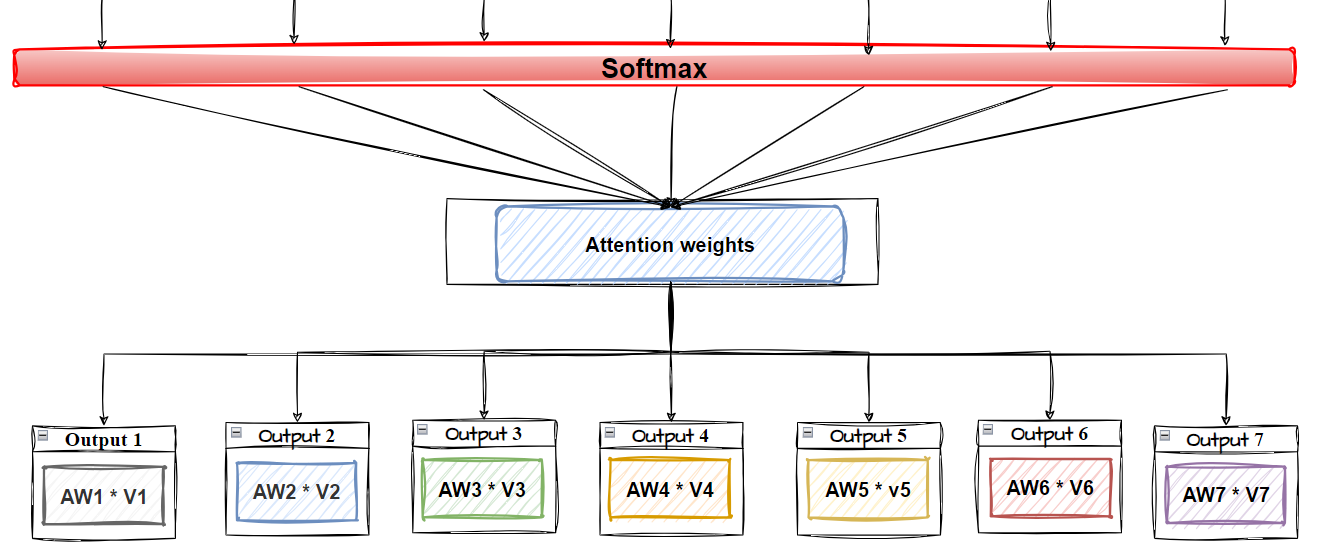

In [ ]:
# Compute the weighted sum of Value vectors
output = torch.matmul(attention_weights.unsqueeze(0), V)
print("Output Vector for 'Le':\n", output)

### Why is Self-Attention Important?

Self-attention allows the model to dynamically adjust its focus based on the context of the sentence, leading to a richer understanding of language. In the case of translation, self-attention helps the model capture the relationships between words, enabling more accurate translations that consider the context.

----

# Multi-Head Attention

Now that we understand self-attention, let's expand on this concept with multi-head attention.

## What is Multi-Head Attention?

Multi-head attention uses multiple attention mechanisms (heads) to capture various aspects of the input simultaneously.

## How Multi-Head Attention Works

   **1. Multiple Attention Heads**:
   - Each head performs its own self-attention operation independently.

   **2. Diverse Perspectives**:
   - Each head learns to focus on different parts of the input sequence, capturing a wide range of relationships and nuances.

   **3. Combining Outputs**:
   - After each head computes its attention output, the results are concatenated and linearly transformed to produce a final output:
     - $$ \text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \text{head}_2, \ldots, \text{head}_h) \cdot W_O $$

**Diagram**: 
- Illustrate the multi-head attention process, showing how outputs from different heads are combined.

By using multiple attention heads, the model can capture diverse relationships between words, such as syntactic structures, semantic meanings, and long-range dependencies. This allows for more accurate translations that consider the overall context of the sentence.